In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import urllib.request
import csv
from bs4 import BeautifulSoup
import locale
from datetime import datetime
import pandas as pd
from sklearn.utils import shuffle
from pandas_datareader import data as web
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re
import string
from tqdm import tqdm
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunkunxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yunkunxu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yunkunxu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
def GetStockPrice(stock, startDate, endDate, method):
    if method == 0:
        Stockdf = web.DataReader(stock, 'yahoo', startDate, endDate)
        NASDAQ = web.DataReader('^IXIC', 'yahoo', startDate, endDate)
        AdjClosedf = pd.DataFrame(Stockdf['Adj Close'].pct_change() - NASDAQ['Adj Close'].pct_change())
        AdjClosedf.loc[:,'Label'] = (AdjClosedf['Adj Close']>0.003).astype(int) - (AdjClosedf['Adj Close']< -0.003).astype(int)

    else:
        page = urllib.request.urlopen('https://finance.yahoo.com/quote/'+stock+'/history?period1=1474095600&period2=1504249200&interval=1d&filter=history&frequency=1d').read()
        soup = BeautifulSoup(page, 'html5lib')
        snap = soup.find("table", class_="W(100%) M(0)")
        snap_body = snap.find('tbody')
        rows = snap_body.find_all('tr')

        #print "Number of data: %d\n" % (len(rows))
        Datelist = []
        AdjCloselist = []

        for element in rows:
            s = element.find_all("span")
            if len(s) == 7:
                Datelist.append(datetime.strptime(s[0].get_text(), '%b %d, %Y'))
                AdjCloselist.append(locale.atof(s[5].get_text().replace(',','')))

        AdjClosedf = pd.DataFrame(AdjCloselist,columns=[stock],index = Datelist)
        #print(AdjClosedf.columns)
        AdjClosedf = AdjClosedf.sort_index()
        AdjClosedf.rename(columns={stock: 'Adj Close'}, inplace=True)
        AdjClosedf.loc[:,'Label'] = (AdjClosedf['Adj Close'].pct_change()>0).astype(int)
        
    return AdjClosedf

In [3]:
def GetStockNews(stock, TopN, DateRange):
    data = {}
    for ndate in tqdm(DateRange):
        data[ndate] = []
        #print ndate.strftime('%Y-%m-%d')
        startdate = ndate.strftime('%Y-%m-%d')
        enddate = startdate
        page = urllib.request.urlopen('https://finance.google.com/finance/company_news?q=NASDAQ%3A'+stock+
                                      '&startdate='+startdate+'&enddate='+enddate).read()
        soup= BeautifulSoup(page, 'html5lib')
        news = soup.find_all("div", class_="g-section news sfe-break-bottom-16")
        #print ("Number of news: %d\n" % (len(news)))
        data[ndate].append(stock)
        for element in news[:TopN]:
            t = element.find_all("span", class_="name")[0].get_text().replace('\xa0',' ').replace('\n','')#.encode('utf-8')
            #print t 
            data[ndate].append(t)
        for i in range(0,TopN - len(news),1):
            data[ndate].append('')
    df = pd.DataFrame().from_dict(data).T
    return df

In [4]:
# for i, stock in tqdm(enumerate(stocklist)):
#     print(stock)
#     if (not os.path.isfile(stock+'.csv')) and (i<50):
#         AdjClosedf = GetStockPrice(stock,start,end,method=0)
#         DateRange = AdjClosedf.index
#         newsdf = GetStockNews(stock, TopN, DateRange)
#         datadf = pd.concat([AdjClosedf.loc[:,'Label'],newsdf],axis = 1)
#         datadf.to_csv(stock+'.csv',encoding= 'utf-8')

In [5]:
# dataset = pd.DataFrame()
# dataset['Headlines'] = datadf.iloc[:-1,2]+' '+ datadf.iloc[:-1,3]+' '+ datadf.iloc[:-1,4]+' '+ datadf.iloc[:-1,5]+' '+ datadf.iloc[:-1,6]+' '+ datadf.iloc[:-1,7]+' '+ datadf.iloc[:-1,8]+' '+ datadf.iloc[:-1,9]+' '+ datadf.iloc[:-1,10]+' '+ datadf.iloc[:-1,11]
# dataset.index = datadf.index[1:]
# dataset['Label'] = datadf['Label'].iloc[1:]
# dataset.head()

### Data Processing

In [6]:
def FilterSentence(headline):
    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
    headline = headline.lower().encode('utf-8').decode('ascii','ignore')
    sentence = tknzr.tokenize(headline)
    sent = nltk.pos_tag(sentence)
    tempfiltered_words = [s[0] for s in sent if s[1][0] in ['J','V','N']]
    stops = set(stopwords.words("english"))
    exclude = set(string.punctuation+'‘’“”0123456789')
    filtered_words = ' '.join(word.lower() for word in tempfiltered_words if (word not in stops) and (word not in exclude))
    filtered_words = re.sub(r'[^\w\s]', '', filtered_words)
    filtered_words = re.sub(r'\d+', '', filtered_words)
    filtered_words = re.sub(r'(.)\1{2,}', r'\1'*2, filtered_words)
    return filtered_words

In [7]:
constituentdf = pd.read_csv('constituents.csv')
stocklist = constituentdf.Symbol.values
stocklist.shape

(505,)

In [8]:
dataset = pd.DataFrame()
for stock in stocklist:
    if os.path.isfile('./NewData/'+stock+'.csv'):
        inputdf = pd.read_csv('./NewData/'+stock+'.csv',index_col=0,encoding='utf_8')
        df = pd.DataFrame()
        #df['Headlines'] = inputdf['1'].iloc[:-1]+' '+ inputdf['2'].iloc[:-1]+' '+ inputdf['3'].iloc[:-1]+' '+ inputdf['4'].iloc[:-1]+' '+ inputdf['5'].iloc[:-1]+' '+ inputdf['6'].iloc[:-1]+' '+ inputdf['7'].iloc[:-1]+' '+ inputdf['8'].iloc[:-1]+' '+ inputdf['9'].iloc[:-1]+' '+ inputdf['10'].iloc[:-1]        
        df['Headlines'] = inputdf.iloc[:,1]+' '+ inputdf.iloc[:,2]+' '+ inputdf.iloc[:,3]+' '+ inputdf.iloc[:,4]+' '+ inputdf.iloc[:,5]+' '+ inputdf.iloc[:,6]+' '+ inputdf.iloc[:,7]+' '+ inputdf.iloc[:-1,8]+' '+ inputdf.iloc[:,9]+' '+ inputdf.iloc[:,10]
        df['Label'] = inputdf['Label']
        df['Stock'] = [stock]*len(inputdf)
        dataset = pd.concat([dataset,df], axis=0)
dataset.head()

,Headlines,Label,Stock
2017-04-17,Smart Investors Are Already Buying These Stock...,0.0,MMM
2017-04-18,"Ann Marie Hanrahan, 3M attorney who championed...",0.0,MMM
2017-04-19,More lucky locals set to share �3m windfall as...,0.0,MMM
2017-04-20,A Retirement Portfolio With Quality Over Quant...,1.0,MMM
2017-04-21,Epson Makes Two Announcements at ISA Expo Enha...,1.0,MMM


In [9]:
# dataset = pd.DataFrame()
# dataset['Headlines'] = df['1'].iloc[:-1]+' '+ df['2'].iloc[:-1]+' '+ df['3'].iloc[:-1]+' '+ df['4'].iloc[:-1]+' '+ df['5'].iloc[:-1]+' '+ df['6'].iloc[:-1]+' '+ df['7'].iloc[:-1]+' '+ df['8'].iloc[:-1]+' '+ df['9'].iloc[:-1]+' '+ df['10'].iloc[:-1]
# dataset.index = df.index[1:]
# dataset['Label'] = df['Label'].iloc[1:]
# dataset.head()

In [10]:
print('Number of stock prices collected:', len(dataset))
print('Number of missing news:', dataset.isnull().values.sum())
data = dataset.dropna(axis=0, how='any')
print('Number of missing news after cleaning:', data.isnull().values.sum())
print('Number of news collected:', len(data))

Number of stock prices collected: 8572
Number of missing news: 2928
Number of missing news after cleaning: 0
Number of news collected: 5717


In [11]:
data['Headlines'] = data['Headlines'].apply(FilterSentence)
data.head()

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Headlines,Label,Stock
2017-04-17,smart investors buying stocks retirement brits...,0.0,MMM
2017-04-18,ann marie hanrahan attorney championed legal r...,0.0,MMM
2017-04-19,lucky locals set share windfall winners postco...,0.0,MMM
2017-04-20,retirement portfolio quality quantity revealed...,1.0,MMM
2017-04-21,epson makes announcements isa expo enhancing s...,1.0,MMM


In [12]:
word_vectorizer = CountVectorizer(analyzer='word', stop_words='english')
sparse_matrix = word_vectorizer.fit_transform(data['Headlines'])
frequencies = sum(sparse_matrix).toarray()[0]
words = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
print(words.describe())
words.head()

          frequency
count  37592.000000
mean       9.816291
std       54.625457
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max     3684.000000


,frequency
aa,9
aaba,6
aacc,2
aacr,1
aade,1


In [13]:
word_vectorizer = CountVectorizer(analyzer='word', stop_words='english',min_df=2, max_df=3000)
sparse_matrix = word_vectorizer.fit_transform(data['Headlines'])
frequencies = sum(sparse_matrix).toarray()[0]
words = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
print(words.describe())
words.head()

          frequency
count  19536.000000
mean      17.957156
std       74.859677
min        2.000000
25%        2.000000
50%        4.000000
75%       11.000000
max     3684.000000


,frequency
aa,9
aaba,6
aacc,2
aadhaar,2
aal,50


In [14]:
del words

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_features = 250
n_components = 20
n_top_words = 10

### Counts
tf_vectorizer = CountVectorizer(min_df=2, max_df=1000, stop_words='english')
tf = tf_vectorizer.fit_transform(data['Headlines'])
tf_feature_names = tf_vectorizer.get_feature_names()
print(tf_feature_names)

['aa', 'aaba', 'aacc', 'aadhaar', 'aal', 'aan', 'aaoi', 'aap', 'aapl', 'aarated', 'aaron', 'aarons', 'aarp', 'aat', 'aaww', 'aaxn', 'ab', 'abacus', 'abandon', 'abandoned', 'abandoning', 'abandons', 'abb', 'abbett', 'abbott', 'abbotts', 'abbv', 'abbvie', 'abbvies', 'abby', 'abbyy', 'abc', 'abcann', 'abdelhak', 'abercrombie', 'aberdeen', 'abev', 'ability', 'abiomed', 'ablation', 'able', 'ableto', 'abmd', 'abnormal', 'aboard', 'abode', 'abortion', 'abound', 'abp', 'abr', 'abraham', 'abraxas', 'abs', 'absence', 'absent', 'absolute', 'absorbs', 'abstract', 'abstracts', 'abt', 'abuse', 'abuses', 'abx', 'aby', 'ac', 'aca', 'acacia', 'acad', 'academic', 'academics', 'academy', 'acadia', 'acadian', 'acbff', 'acc', 'accelerate', 'accelerated', 'accelerates', 'accelerating', 'acceleration', 'accelerator', 'accelerators', 'acceleron', 'accenture', 'accentures', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'accern', 'access', 'accessibility', 'accessible', 'accessories'

In [16]:
## TF-IDF
tfidf_vectorizer = TfidfVectorizer(min_df=2,max_df=1000,stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data['Headlines'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print(tfidf_feature_names)

['aa', 'aaba', 'aacc', 'aadhaar', 'aal', 'aan', 'aaoi', 'aap', 'aapl', 'aarated', 'aaron', 'aarons', 'aarp', 'aat', 'aaww', 'aaxn', 'ab', 'abacus', 'abandon', 'abandoned', 'abandoning', 'abandons', 'abb', 'abbett', 'abbott', 'abbotts', 'abbv', 'abbvie', 'abbvies', 'abby', 'abbyy', 'abc', 'abcann', 'abdelhak', 'abercrombie', 'aberdeen', 'abev', 'ability', 'abiomed', 'ablation', 'able', 'ableto', 'abmd', 'abnormal', 'aboard', 'abode', 'abortion', 'abound', 'abp', 'abr', 'abraham', 'abraxas', 'abs', 'absence', 'absent', 'absolute', 'absorbs', 'abstract', 'abstracts', 'abt', 'abuse', 'abuses', 'abx', 'aby', 'ac', 'aca', 'acacia', 'acad', 'academic', 'academics', 'academy', 'acadia', 'acadian', 'acbff', 'acc', 'accelerate', 'accelerated', 'accelerates', 'accelerating', 'acceleration', 'accelerator', 'accelerators', 'acceleron', 'accenture', 'accentures', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'accern', 'access', 'accessibility', 'accessible', 'accessories'

### Finding topics with LDA

In [17]:
lda = LatentDirichletAllocation(n_components, learning_method='online', random_state=1)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=1, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [18]:
print("\nTopics in LDA model:")
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0: materials global applied energy auto parts industry advance expands amat
Topic #1: apple netflix aapl trump nflx watch iphone tech date june
Topic #2: shop art ps love provide injured phoenix death counties killed
Topic #3: management capital stake nyse investment position shares buys company nasdaq
Topic #4: facebook amazon ebay fb google best amazoncom amzn big data
Topic #5: special card police battlefront planning trailer visa chris stolen car
Topic #6: anthem health aetna amgen obamacare insurance apartments insurers antm box
Topic #7: baxter lost acquisitions packaging mondays vehicle billionaire electric george path
Topic #8: chance attractive figures disneys dropped dominos latest unfortunate zimmer winstonsalem
Topic #9: global autodesk adsk growth analysis abbott size industry money cramers
Topic #10: alphabet arts electronic ea googl game activision blizzard games video
Topic #11: news ratings receive daily area combat oa israeli rs viacom
Top

In [19]:
lda = LatentDirichletAllocation(n_components, learning_method='online', random_state=1)
lda.fit(tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=1, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [20]:
print("\nTopics in LDA model:")
print_top_words(lda, tfidf_feature_names, n_top_words)


Topics in LDA model:
Topic #0: brendan toxicity mobius templates artery functioning insidetrading sh radiotherapy uveitis
Topic #1: liverpool scandals triggered relocates supplements turnover walters appetites ponzi elysium
Topic #2: slowest prestons cobb ty corrected tucker aston provide ny guide
Topic #3: apple facebook netflix amazon fb ebay american best company global
Topic #4: giveaway sohn accuse distanced servisfirst thunderdome labours wouldbe investigational diode
Topic #5: donated championed grinding cohost kaplan kluger microchips swansea coleader lardner
Topic #6: coin microfluidics microarrays violated sito modis asap restructure influenza bacterial
Topic #7: consoles atari bedding katie ddos flashback jasmine diligence limerick overspend
Topic #8: imlff inmed sedan mankato springboard macmillan prezola synchro stifling pounded
Topic #9: reopens recession tosses nut doomed aliens disbands engaging lurie gigantic
Topic #10: eddie slaves gophers dyche sh truelayer norwich 

### Sentiment Analysis

In [21]:
positive = pd.read_csv('positive-words.txt', names=['a'], encoding='latin-1')
positive =  set(positive['a'].tolist())

negative = pd.read_csv('negative-words.txt', names=['a'], encoding='latin-1')
negative =  set(negative['a'].tolist())

In [22]:
count_positive = []
count_negative = []
for i, row in data.iterrows():
    commonp = set(row['Headlines'].split()).intersection(positive) 
    count_positive.append(len(commonp))
    commonn = set(row['Headlines'].split()).intersection(negative) 
    count_negative.append(len(commonn))


In [23]:
data['positive'] = count_positive
data['negative'] = count_negative

data.head()

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Headlines,Label,Stock,positive,negative
2017-04-17,smart investors buying stocks retirement brits...,0.0,MMM,7,2
2017-04-18,ann marie hanrahan attorney championed legal r...,0.0,MMM,2,1
2017-04-19,lucky locals set share windfall winners postco...,0.0,MMM,8,5
2017-04-20,retirement portfolio quality quantity revealed...,1.0,MMM,3,2
2017-04-21,epson makes announcements isa expo enhancing s...,1.0,MMM,3,2


#### Encoding features

In [24]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data.Stock.unique())
data.Stock = le.transform(data.Stock)

data.head()

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Headlines,Label,Stock,positive,negative
2017-04-17,smart investors buying stocks retirement brits...,0.0,68,7,2
2017-04-18,ann marie hanrahan attorney championed legal r...,0.0,68,2,1
2017-04-19,lucky locals set share windfall winners postco...,0.0,68,8,5
2017-04-20,retirement portfolio quality quantity revealed...,1.0,68,3,2
2017-04-21,epson makes announcements isa expo enhancing s...,1.0,68,3,2


In [25]:
data.describe()

,Label,Stock,positive,negative
count,5717.000000,5717.000000,5717.000000,5717.000000
mean,0.031135,38.336715,2.588945,2.241210
std,0.831969,22.711816,1.601916,1.761415
min,-1.000000,0.000000,0.000000,0.000000
25%,-1.000000,16.000000,1.000000,1.000000
50%,0.000000,39.000000,2.000000,2.000000
75%,1.000000,61.000000,4.000000,3.000000
max,1.000000,71.000000,13.000000,19.000000


In [26]:
data_up = data.loc[data['Label'] == 1]
data_down = data.loc[data['Label'] == -1]
print(len(data_up), len(data_down))
print("Percentage of positve sentiments  : %s " % (len(data_up)* 100.0 / (len(data_up) + len(data_down))))
print("Percentage of negative sentiments : %s " % (len(data_down)* 100.0 / (len(data_up) + len(data_down))))

2070 1892
Percentage of positve sentiments  : 52.24634023220596 
Percentage of negative sentiments : 47.75365976779404 


In [28]:
data = data_up.append(data_down)
dataset_X = data.drop('Label',axis=1)
dataset_y = data['Label']
print(len(dataset_X), len(dataset_y))

3962 3962


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(dataset_X,dataset_y,test_size=0.2,stratify=dataset_y,random_state=1)

down = y_train[y_train == -1].count()
up = y_train[y_train == 1].count()
print(up*100/down)

down2 = y_test[y_test == -1].count()
up2 = y_test[y_test == 1].count()
print(up2*100/down2)


109.451421018
109.234828496


### Word2Vec

In [31]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [32]:
from gensim import matutils
matrix_train = []
for i in range(len(X_train)):
    row = X_train.iloc[i,:]
    filtered_text = [model[w] for w in row['Headlines'].split() if w in model]
    if len(filtered_text):
        matrix_train.append(matutils.unitvec(np.array(filtered_text).mean(axis=0)))


In [33]:
matrix_train = np.array(matrix_train)
print(matrix_train.shape)
sim_train = np.dot(matrix_train, matrix_train.transpose())
print(sim_train)

(3169, 300)
[[ 1.          0.73619725  0.67000631 ...,  0.71990682  0.68104904
   0.6026356 ]
 [ 0.73619725  1.          0.7759827  ...,  0.80455755  0.71749343
   0.61691373]
 [ 0.67000631  0.7759827   1.         ...,  0.8166857   0.741       0.72684737]
 ..., 
 [ 0.71990682  0.80455755  0.8166857  ...,  1.          0.80687764
   0.70007552]
 [ 0.68104904  0.71749343  0.741      ...,  0.80687764  1.          0.73465269]
 [ 0.6026356   0.61691373  0.72684737 ...,  0.70007552  0.73465269  1.        ]]


In [34]:
print(sim_train.shape)
np.fill_diagonal(sim_train, 0)
# simdf_train = pd.DataFrame(list(sim_train[np.triu_indices(sim_train.shape[1], 1)]))
# simdf_train.describe()

(3169, 3169)


In [35]:
overview_train = pd.concat([X_train,y_train],axis=1)
overview_train.head()

,Headlines,Stock,positive,negative,Label
2017-08-22,facebook buy macys names ebay senior vp lawton...,62,0,0,1.0
2017-05-24,digging facts intuit inc intu investors remain...,24,3,0,1.0
2017-08-08,archerdanielsmidland company adm stock price n...,10,5,2,1.0
2016-11-25,apple stopped disclosing much spends ads watch...,3,3,3,1.0
2017-05-31,beer pioneer jim shares secrets sam lavar decl...,60,6,1,1.0


In [36]:
#### Get the most similar tweets for each sentiment
up = 1
most_similar = np.argmax(sim_train[up][:])
print("similarity:", sim_train[up][most_similar])
print(X_train.iloc[up].Headlines)
print()
print(X_train.iloc[most_similar].Headlines)

similarity: 0.893360677595
digging facts intuit inc intu investors remained confident chegg inc chgg inc qrvo clearsky data launches partner acceleration program continued growth stocks buzz mannkind corporation nasdaq mnkd bank ag usa nyse stocks lookout seadrill ltd nyse sdrl sanchez energy corp nyse sn trending stocks analyst review activision blizzard inc nasdaq atvi worthy stocks watch ggp inc nyse ggp cousins properties inc nyse cuz steps great apm dashboards instagram rolls new archive feature hides posts deleting flipkart applies license become gst suvidha provider

comparing price charts consolidated edison inc ed akamai technologies stanleylaman group ltd buys altria group inc pfizer inc gilead sciences akamai technologies inc akam describing technical facts ratio big stock rallies short theyre dish network corporation nasdaq d ish stake maintained meeder asset drilling books fidelity national information services inc glatfelter nyse glt upgraded buy valuengine cloud services

In [37]:
#### Get the most similar tweets for each sentiment
down = 0
most_similar = np.argmax(sim_train[down][:])
print("similarity:", sim_train[down][most_similar])
print(X_train.iloc[down].Headlines)
print()
print(X_train.iloc[most_similar].Headlines)

similarity: 0.956065884117
facebook buy macys names ebay senior vp lawton new president ebay announces changes regional leadership team ebay earnings report rebound ebay inc nasdaq ebay files k departure directors certain investors see ebay inc ebay ebay inc ebay position held richard bernstein advisors llc marble harbor investment counsel llc raised ebay inc ebay holding valuing stocks using ratios multiples ebay inc ebay csx corporation equity perception analysts indicator review dynegy inc dyn ebay inc

oneweek preearnings momentum trade options ebay inc major analyst actions review baozun inc bzun ebay inc ebay federated investors inc pa reduces stake ebay inc ebay ebay inc ebay noted price change first republic bank frc critical levels breach darden restaurants inc dri ebay inc ebay americas winnertakeall industry visualized investors warm notion immelt uber ceo ebay inc ebay see trading action aug macys taps former new president ebay inc nasdaq ebay option buy sell


#### Use PCA to reduce overfitting

In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
pca.fit(matrix_train)
matrix_t_train = pca.transform(matrix_train)

print(pca.explained_variance_ratio_)

[ 0.11015697  0.09166025  0.04394979  0.03851141  0.02797189  0.02613288
  0.02292226  0.02097696  0.01856353  0.01640582  0.01528179  0.01440172
  0.01350402  0.01238501  0.01171759  0.01060902  0.00973511  0.00964991
  0.00877906  0.00835815  0.00820371  0.00791059  0.00715216  0.00694167
  0.00676649  0.00650682  0.00634678  0.00615419  0.00597239  0.00565296
  0.00555842  0.00523338  0.00519172  0.00502179  0.00491076  0.00466109
  0.00451065  0.00441083  0.00437935  0.00422395  0.00414519  0.00408764
  0.00406475  0.00391874  0.00385145  0.00383538  0.00374261  0.00367104
  0.00364273  0.00343885  0.00339837  0.00332656  0.00330047  0.00323454
  0.00318593  0.00315819  0.00310005  0.00302136  0.00298176  0.00296244
  0.00290301  0.00284474  0.00281055  0.00280476  0.00275296  0.00274785
  0.00270764  0.00263935  0.00261113  0.00260432  0.00258633  0.00252476
  0.00250321  0.0024747   0.00244899  0.00243542  0.00237091  0.002351
  0.00233431  0.00227911  0.00226087  0.00225106  0.0

In [39]:
train1 = X_train.drop('Headlines',axis=1)
train1.index = range(len(train1))
#train1_scaled = pd.DataFrame(preprocessing.scale(train1),index=train1.index,columns=train1.columns)
train2 = pd.DataFrame(matrix_t_train)
# print test.index
# print test2.index
train3 = pd.concat([train1, train2], axis=1)
train3.head()

,Stock,positive,negative,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,62,0,0,-0.241895,0.319927,-0.116572,-0.062776,-0.095514,-0.022521,0.074516,...,-0.004155,0.002187,-0.001307,0.000075,-0.006773,0.006563,-0.001303,-0.007791,0.000673,0.004768
1,24,3,0,-0.301047,0.103673,-0.080673,-0.009722,-0.032155,0.037226,-0.102367,...,0.003956,-0.011219,0.003333,-0.002945,0.003432,0.013311,-0.004435,-0.000625,0.000168,-0.005527
2,10,5,2,-0.256408,-0.076587,0.022786,-0.054962,0.123872,-0.018088,-0.034081,...,0.005485,0.003322,0.001876,0.008082,-0.008608,-0.004666,-0.008698,-0.008500,0.005910,-0.000162
3,3,3,3,0.277921,0.139493,0.156503,0.113173,0.072123,0.027273,0.149223,...,-0.001450,-0.001729,-0.008653,-0.004378,-0.015280,-0.002575,-0.000019,-0.009032,-0.002716,-0.002582
4,60,6,1,0.103608,-0.066755,0.055591,0.124579,0.102956,-0.056688,-0.047966,...,-0.004149,-0.002077,0.002188,0.008540,0.017786,-0.014450,-0.008510,0.015345,0.017057,0.008511


In [40]:
train3_scaled = pd.DataFrame(preprocessing.scale(train3),index=train3.index,columns=train3.columns)
train3_scaled.head()

,Stock,positive,negative,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,1.071750,-1.627353,-1.277323,-1.375884,1.994902,-1.049728,-0.603897,-1.078123,-0.263003,0.929145,...,-0.404210,0.215384,-0.131456,0.007683,-0.694859,0.692892,-0.137960,-0.884861,0.080863,0.624516
1,-0.614017,0.240253,-1.277323,-1.712340,0.646452,-0.726459,-0.093527,-0.362955,0.434726,-1.276420,...,0.384847,-1.105127,0.335133,-0.300292,0.352028,1.405223,-0.469696,-0.071016,0.020158,-0.723937
2,-1.235089,1.485323,-0.133382,-1.458435,-0.477560,0.205192,-0.528725,1.398218,-0.211230,-0.424956,...,0.533608,0.327266,0.188630,0.823913,-0.883084,-0.492632,-0.921056,-0.965369,0.710322,-0.021193
3,-1.545625,0.240253,0.438589,1.580802,0.869807,1.409309,1.088703,0.814096,0.318491,1.860668,...,-0.141021,-0.170287,-0.870033,-0.446294,-1.567467,-0.271862,-0.002014,-1.025770,-0.326444,-0.338165
4,0.983026,2.107858,-0.705353,0.589319,-0.416248,0.500600,1.198426,1.162120,-0.661999,-0.598095,...,-0.403597,-0.204586,0.220035,0.870669,1.824566,-1.525503,-0.901147,1.742684,2.050157,1.114685


In [41]:
X_train = train3_scaled
print(len(X_train))

3169


In [42]:
matrix_test = []
for i in range(len(X_test)):
    row = X_test.iloc[i,:]
    filtered_text = [model[w] for w in row['Headlines'].split() if w in model]
    if len(filtered_text):
        matrix_test.append(matutils.unitvec(np.array(filtered_text).mean(axis=0)))

In [43]:
matrix_test = np.array(matrix_test)
print(matrix_test.shape)
sim_test = np.dot(matrix_test, matrix_test.transpose())
print(sim_test)

(793, 300)
[[ 1.          0.76321792  0.78483807 ...,  0.71289945  0.68602599
   0.67976319]
 [ 0.76321792  1.          0.76968884 ...,  0.79844061  0.84402001
   0.83244172]
 [ 0.78483807  0.76968884  1.         ...,  0.68265847  0.69359009
   0.70447836]
 ..., 
 [ 0.71289945  0.79844061  0.68265847 ...,  1.          0.71221091
   0.71570762]
 [ 0.68602599  0.84402001  0.69359009 ...,  0.71221091  1.          0.82538156]
 [ 0.67976319  0.83244172  0.70447836 ...,  0.71570762  0.82538156  1.        ]]


In [44]:
matrix_t_test = pca.transform(matrix_test)
test1 = X_test.drop('Headlines',axis=1)
test1.index = range(len(test1))
#test1_scaled = pd.DataFrame(preprocessing.scale(test1),index=test1.index,columns=test1.columns)
test2 = pd.DataFrame(matrix_t_test)
# print test.index
# print test2.index
test3 = pd.concat([test1, test2], axis=1)
test3.head()

,Stock,positive,negative,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,58,3,3,-0.006110,-0.294802,-0.031178,0.052511,-0.033733,0.036985,0.156703,...,-0.008168,0.005048,0.011998,0.023320,0.027280,0.000471,0.006222,-0.002368,0.004979,-0.010058
1,69,4,4,-0.162421,0.006421,-0.033678,0.076332,0.062467,-0.017939,0.045670,...,-0.001989,0.003128,-0.010855,0.006397,0.012338,-0.005282,-0.004866,-0.017529,-0.004165,0.012410
2,53,1,2,0.185396,-0.143404,0.036284,-0.011778,0.017429,-0.039073,0.086423,...,-0.004111,-0.007055,-0.015333,0.017424,-0.018762,-0.009631,-0.029849,-0.006008,-0.013941,0.016965
3,32,4,4,0.235388,-0.162275,-0.099201,-0.051770,-0.050282,0.031421,0.058570,...,-0.020440,0.007522,-0.013250,0.000987,-0.011232,-0.035478,0.004181,0.011176,0.001790,0.003011
4,30,1,2,-0.024906,-0.129929,0.080351,0.018153,0.042380,-0.114801,-0.018508,...,0.010519,-0.013669,0.020706,-0.018453,0.006862,-0.025386,-0.008325,0.002150,-0.003910,-0.008437


In [45]:
test3_scaled = pd.DataFrame(preprocessing.scale(test3),index=test3.index,columns=test3.columns)
test3_scaled.head()

,Stock,positive,negative,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,0.857640,0.282085,0.397097,-0.077215,-1.890628,-0.202338,0.482648,-0.379464,0.430178,2.011883,...,-0.663480,0.461801,0.987057,1.943607,2.237064,0.000021,0.555223,-0.099261,0.474582,-1.110248
1,1.348596,0.913987,0.960420,-0.934027,0.038006,-0.224095,0.725199,0.692128,-0.207166,0.606543,...,-0.166562,0.305237,-0.831872,0.523269,0.985954,-0.506218,-0.412899,-1.565414,-0.452963,1.462438
2,0.634478,-0.981720,-0.166227,0.972520,-0.921274,0.384857,-0.171958,0.190442,-0.452397,1.122351,...,-0.337163,-0.525257,-1.188306,1.448712,-1.618093,-0.888861,-2.594147,-0.451261,-1.444502,1.983991
3,-0.302802,0.913987,0.960420,1.246552,-1.042101,-0.794411,-0.579170,-0.563812,0.365604,0.769814,...,-1.650421,0.663617,-1.022525,0.069266,-0.987599,-3.163297,0.377016,1.210498,0.151093,0.386275
4,-0.392067,-0.981720,-0.166227,-0.180241,-0.835000,0.768416,0.132807,0.468378,-1.331145,-0.205757,...,0.839452,-1.064634,1.680221,-1.562324,0.527400,-2.275292,-0.714907,0.337638,-0.427070,-0.924656


In [46]:
X_test = test3_scaled
print(len(X_test))

793


### Train, validate and test a classification algorithm

### Random Froest
#### Tunning Hyperparameters

1. max_features = ['auto','log2','sqrt']
2. min_samples_leaf = [1,5,10,50,100]
3. n_estimators = [300, 500, 1000, 5000]

In [55]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, split in enumerate(['auto','log2','sqrt']):
    clf = RandomForestClassifier(n_estimators=500,max_features=split,random_state=42,n_jobs=-1)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    fpr[i], tpr[i], _ = roc_curve(y_predict, y_test, pos_label=1)
    print('Accuracy score:', accuracy_score(y_test, y_predict))
    f_score = f1_score(y_test, y_predict, average='weighted')
    print('F1 score:', f_score)
    crossdf = pd.crosstab(y_test, y_predict, rownames=["Actual"], colnames=["Predicted"])
    print(crossdf)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
print(roc_auc)

Accuracy score: 0.534678436318
F1 score: 0.513780852509
Predicted  -1.0   1.0
Actual               
-1.0        121   258
 1.0        111   303
Accuracy score: 0.522068095839
F1 score: 0.488556403167
Predicted  -1.0   1.0
Actual               
-1.0         97   282
 1.0         97   317
Accuracy score: 0.534678436318
F1 score: 0.513780852509
Predicted  -1.0   1.0
Actual               
-1.0        121   258
 1.0        111   303
{0: 0.53082933800479437, 1: 0.51460767946577635, 2: 0.53082933800479437}


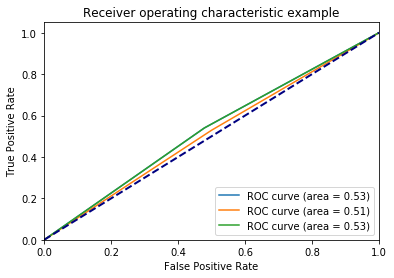

In [56]:
plt.figure()
lw = 2
for i, f in enumerate(fpr):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [57]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, leaf_size in enumerate([1,5,10,50,100]):
    clf = RandomForestClassifier(n_estimators=500,max_features='auto',min_samples_leaf=leaf_size,random_state=42,n_jobs=-1)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    fpr[i], tpr[i], _ = roc_curve(y_predict, y_test, pos_label=1)
    print('Accuracy score:', accuracy_score(y_test, y_predict))
    f_score = f1_score(y_test, y_predict, average='weighted')
    print('F1 score:', f_score)
    crossdf = pd.crosstab(y_test, y_predict, rownames=["Actual"], colnames=["Predicted"])
    print(crossdf)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
print(roc_auc)

Accuracy score: 0.534678436318
F1 score: 0.513780852509
Predicted  -1.0   1.0
Actual               
-1.0        121   258
 1.0        111   303
Accuracy score: 0.534678436318
F1 score: 0.501347646165
Predicted  -1.0   1.0
Actual               
-1.0        101   278
 1.0         91   323
Accuracy score: 0.546027742749
F1 score: 0.500857896074
Predicted  -1.0   1.0
Actual               
-1.0         89   290
 1.0         70   344
Accuracy score: 0.52711223203
F1 score: 0.437204060475
Predicted  -1.0   1.0
Actual               
-1.0         43   336
 1.0         39   375
Accuracy score: 0.515762925599
F1 score: 0.385647814529
Predicted  -1.0   1.0
Actual               
-1.0         15   364
 1.0         20   394
{0: 0.53082933800479437, 1: 0.53173963533000557, 2: 0.55116758923079978, 3: 0.52590820211999589, 4: 0.47418017338861668}


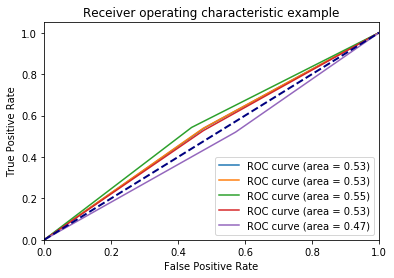

In [58]:
plt.figure()
lw = 2
for i, f in enumerate(fpr):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [60]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, n_estimators in enumerate([300, 500, 1000, 5000]):
    clf = RandomForestClassifier(n_estimators,max_features='auto',min_samples_leaf=10,random_state=42,n_jobs=-1)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    fpr[i], tpr[i], _ = roc_curve(y_predict, y_test, pos_label=1)
    print('Accuracy score:', accuracy_score(y_test, y_predict))
    f_score = f1_score(y_test, y_predict, average='weighted')
    print('F1 score:', f_score)
    crossdf = pd.crosstab(y_test, y_predict, rownames=["Actual"], colnames=["Predicted"])
    print(crossdf)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
print(roc_auc)

Accuracy score: 0.520807061791
F1 score: 0.482330511019
Predicted  -1.0   1.0
Actual               
-1.0         90   289
 1.0         91   323
Accuracy score: 0.546027742749
F1 score: 0.500857896074
Predicted  -1.0   1.0
Actual               
-1.0         89   290
 1.0         70   344
Accuracy score: 0.52711223203
F1 score: 0.475983287179
Predicted  -1.0   1.0
Actual               
-1.0         77   302
 1.0         73   341
Accuracy score: 0.532156368222
F1 score: 0.466478699756
Predicted  -1.0   1.0
Actual               
-1.0         64   315
 1.0         56   358
{0: 0.51250767341927561, 1: 0.55116758923079978, 2: 0.52182996371176782, 3: 0.53263992075284783}


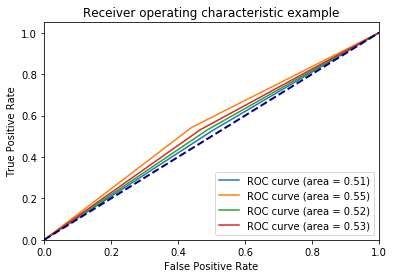

In [61]:
plt.figure()
lw = 2
for i, f in enumerate(fpr):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression
#### Tuning Parameters

1. penalty = ['l1','l2']
2. C = [0.00001,0.001,1.0,10.0,100.0]

In [66]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, p in enumerate(['l1','l2']):
    LR_clf = LogisticRegression(penalty=p,random_state=1)
    LR_clf.fit(X_train, y_train)
    y_predict = LR_clf.predict(X_test)
    fpr[i], tpr[i], _ = roc_curve(y_predict, y_test, pos_label=1)
    print('Accuracy score:', accuracy_score(y_test, y_predict))
    f_score = f1_score(y_test, y_predict, average='weighted')
    print('F1 score:', f_score)
    crossdf = pd.crosstab(y_test, y_predict, rownames=["Actual"], colnames=["Predicted"])
    print(crossdf)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
print(roc_auc)

Accuracy score: 0.481715006305
F1 score: 0.479123053131
Predicted  -1.0   1.0
Actual               
-1.0        153   226
 1.0        185   229
Accuracy score: 0.486759142497
F1 score: 0.484192415144
Predicted  -1.0   1.0
Actual               
-1.0        155   224
 1.0        183   231
{0: 0.47797971259509719, 1: 0.4831360946745562}


In [67]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, C in enumerate([0.00001, 0.001, 1.0, 10.0, 100.0]):
    LR_clf = LogisticRegression(penalty='l2',C=C)
    LR_clf.fit(X_train, y_train)
    y_predict = LR_clf.predict(X_test)
    fpr[i], tpr[i], _ = roc_curve(y_predict, y_test, pos_label=1)
    print('Accuracy score:', accuracy_score(y_test, y_predict))
    f_score = f1_score(y_test, y_predict, average='weighted')
    print('F1 score:', f_score)
    crossdf = pd.crosstab(y_test, y_predict, rownames=["Actual"], colnames=["Predicted"])
    print(crossdf)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
print(roc_auc)

Accuracy score: 0.494325346784
F1 score: 0.491601955478
Predicted  -1.0   1.0
Actual               
-1.0        157   222
 1.0        179   235
Accuracy score: 0.490542244641
F1 score: 0.487897304069
Predicted  -1.0   1.0
Actual               
-1.0        156   223
 1.0        181   233
Accuracy score: 0.486759142497
F1 score: 0.484192415144
Predicted  -1.0   1.0
Actual               
-1.0        155   224
 1.0        183   231
Accuracy score: 0.486759142497
F1 score: 0.484192415144
Predicted  -1.0   1.0
Actual               
-1.0        155   224
 1.0        183   231
Accuracy score: 0.486759142497
F1 score: 0.484192415144
Predicted  -1.0   1.0
Actual               
-1.0        155   224
 1.0        183   231
{0: 0.49074254975513187, 1: 0.48693646207506891, 2: 0.4831360946745562, 3: 0.4831360946745562, 4: 0.4831360946745562}


#### Final Model

In [62]:
clf = RandomForestClassifier(n_estimators=500,max_features='auto',min_samples_leaf=10,random_state=42,n_jobs=-1)
scoring = {'accuracy': make_scorer(accuracy_score),'prec': 'precision'}
#cv_results = cross_validation(clf.fit(X_train, y_train), X_train, y_train, scoring=scoring)

In [63]:
print(cross_val_score(clf, X_train, y_train))

[ 0.51750237  0.50189394  0.52272727]


In [64]:
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
fpr, tpr, _ = roc_curve(y_predict, y_test, pos_label=1)
print('Accuracy score:', accuracy_score(y_test, y_predict))
f_score = f1_score(y_test, y_predict, average='weighted')
print('F1 score:', f_score)
crossdf = pd.crosstab(y_test, y_predict, rownames=["Actual"], colnames=["Predicted"])
print(crossdf)
roc_auc = auc(fpr, tpr)
print(roc_auc)

Accuracy score: 0.546027742749
F1 score: 0.500857896074
Predicted  -1.0   1.0
Actual               
-1.0         89   290
 1.0         70   344
0.551167589231


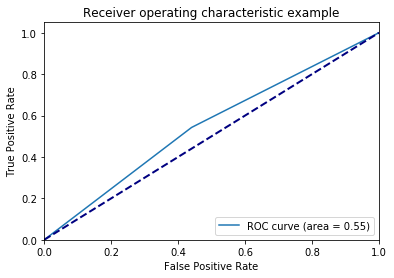

In [65]:
plt.figure()
lw = 2

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()